# NHP3s - Non-human primate data Fano factor analysis (replication subject only)
# Cross-trial analysis 

## Takuya Ito
#### 03/23/2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import sys
import h5py
import statsmodels.api as sm
import analysisNHP as analysis


# Set up data parameters

In [2]:
## All sessions (both subjects included)
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing

# Load in monkeyIDs
idfile = datadir + 'monkeyToSessionID.csv'
monkeyTable = pd.read_csv(idfile,delimiter=',')

replication_sessions = 0
monkeyID = {}
for i in range(1, len(sessions)+1):
    if i < 10:
        sess_str = 'session_ ' + str(i)
        name_str = 'name_ '  + str(i)
    else:
        sess_str = 'session_' + str(i)
        name_str = 'name_'  + str(i)
    
    session = str(monkeyTable[sess_str][0])
    name = monkeyTable[name_str][0]

    if name=='paula':
        replication_sessions += 1
        
    if session=='110111_02.mat': session = '110111_02'
        
    monkeyID[session] = name
    
exploratory_sessions = len(sessions) - replication_sessions
print 'Number of sessions with exploratory subject:', exploratory_sessions 
print 'Number of sessions with replication subject', replication_sessions
    
regions = ['PFC', 'FEF', 'LIP', 'MT', 'IT', 'V4']

Number of sessions with exploratory subject: 16
Number of sessions with replication subject 39


# 1.0 Load all sessions for replication subject

#### Load other meta-data associated with neurons + task info

#### Compute downsampled firing rate using 50ms bins and 10ms shift

In [3]:
analysis = reload(analysis)
spikes_binned = {}
mocolInfo = {}
areas = {}

sessioncount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='paula': continue
    print 'Loading data for session', session, '|', sessioncount, '/', replication_sessions
    
    taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
    mocolTrials = np.where(taskInfo['task']=='mocol')[0]
    mocolInfo[session] = pd.read_csv(datadir + session + '_trialInfoMOCOL.csv')
    areas[session] = np.squeeze(pd.read_csv(datadir + session + '_areaIndices_v2.csv').values)
    
    # Find the number of neurons per area in the session
    unitInfo = pd.read_csv(datadir + session + '_unitInfo.csv')
    area_ind = np.asarray(unitInfo.area.values)
    
    ####
    h5f = h5py.File(datadir + session + '_perArea_v2.h5', 'r')
    # Columns for h5f are reversed between matlab and python | Output is time x neuron x trials
    spikes_binned[session] = analysis.spikeBinning(h5f['sta'][mocolTrials,:,:].T,binSize=50,shiftSize=10)
    h5f.close() 
    
    # Now normalize number of spikes per regions by number of neurons
    i = 0
    for area in areas[session]:
        ncells = len(np.where(area_ind==area)[0])
        spikes_binned[session][i,:,:] = np.divide(spikes_binned[session][i,:,:],ncells)
        i += 1
        
        
    sessioncount += 1
    

Loading data for session 100706 | 1 / 39
Loading data for session 100730 | 2 / 39
Loading data for session 100804 | 3 / 39
Loading data for session 100820 | 4 / 39
Loading data for session 100827 | 5 / 39
Loading data for session 101122 | 6 / 39
Loading data for session 101128 | 7 / 39
Loading data for session 101207 | 8 / 39
Loading data for session 101217 | 9 / 39
Loading data for session 110110_01 | 10 / 39
Loading data for session 110115_01 | 11 / 39
Loading data for session 100724 | 12 / 39
Loading data for session 100731 | 13 / 39
Loading data for session 100817 | 14 / 39
Loading data for session 100823 | 15 / 39
Loading data for session 100828 | 16 / 39
Loading data for session 101123 | 17 / 39
Loading data for session 101202 | 18 / 39
Loading data for session 101209 | 19 / 39
Loading data for session 110106 | 20 / 39
Loading data for session 110110_02 | 21 / 39
Loading data for session 100725 | 22 / 39
Loading data for session 100802 | 23 / 39
Loading data for session 100818 | 

# Perform main analyses for replication subject

In [4]:
analysis = reload(analysis)
ff_rest = []
ff_task = []


totalFF = []
    
sesscount = 1
for session in sessions:
    # Sort exploratory v replication sessions by subject ID
    if monkeyID[session]!='paula': continue
    print 'Computing statistics for session', session, '|', sesscount, '/', replication_sessions
    
    ####
    tasksByTrial = mocolInfo[session]['rule'].astype(str)
    for condition in ['color','motion']:
        ind = np.where(tasksByTrial==condition)[0]
        cond_mocolInfo = mocolInfo[session].iloc[ind]
        
        tmp_rest, tmp_task = analysis.computeFanoFactor(spikes_binned[session][:,:,ind],cond_mocolInfo,areas[session],normalize=False)
        ff_rest.extend(tmp_rest)
        ff_task.extend(tmp_task)
        
    
#     # Remove any neurons with 0 spikes for either condition (since ff would be undefined (mean of 0 spikes))
#     nospikeneurons_rest = np.where(np.isnan(ff_rest_percond))[0] 
#     nospikeneurons_task = np.where(np.isnan(ff_task_percond))[0] 
#     nospikeneurons_all = np.hstack((nospikeneurons_rest, nospikeneurons_task))

#     tmp_ff_rest = np.delete(ff_rest_percond,nospikeneurons_all)
#     tmp_ff_task = np.delete(ff_task_percond,nospikeneurons_all)
    
    sesscount += 1


Computing statistics for session 100706 | 1 / 39


analysisNHP.py:468: RuntimeWarning: invalid value encountered in divide
  ff_rest.append(np.divide(var_rest,mu_rest))
analysisNHP.py:469: RuntimeWarning: invalid value encountered in divide
  ff_task.append(np.divide(var_task,mu_task))


Computing statistics for session 100730 | 2 / 39
Computing statistics for session 100804 | 3 / 39
Computing statistics for session 100820 | 4 / 39
Computing statistics for session 100827 | 5 / 39
Computing statistics for session 101122 | 6 / 39
Computing statistics for session 101128 | 7 / 39
Computing statistics for session 101207 | 8 / 39
Computing statistics for session 101217 | 9 / 39
Computing statistics for session 110110_01 | 10 / 39
Computing statistics for session 110115_01 | 11 / 39
Computing statistics for session 100724 | 12 / 39
Computing statistics for session 100731 | 13 / 39
Computing statistics for session 100817 | 14 / 39
Computing statistics for session 100823 | 15 / 39
Computing statistics for session 100828 | 16 / 39
Computing statistics for session 101123 | 17 / 39
Computing statistics for session 101202 | 18 / 39
Computing statistics for session 101209 | 19 / 39
Computing statistics for session 110106 | 20 / 39
Computing statistics for session 110110_02 | 21 / 39

## Compute statistics for replication subject

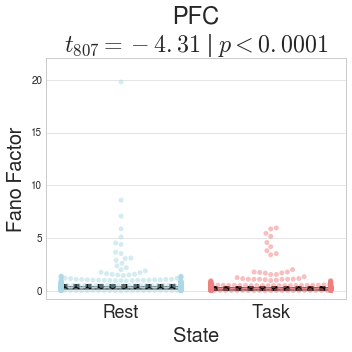

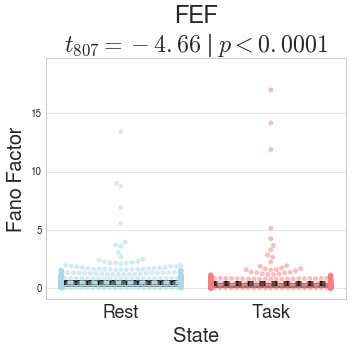

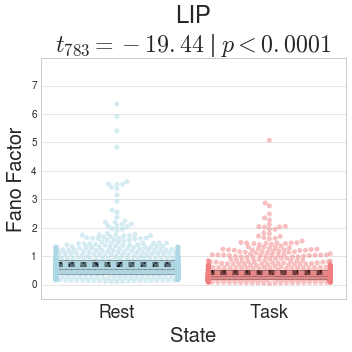

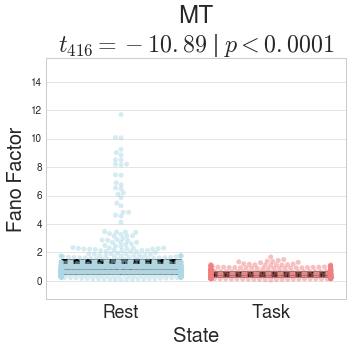

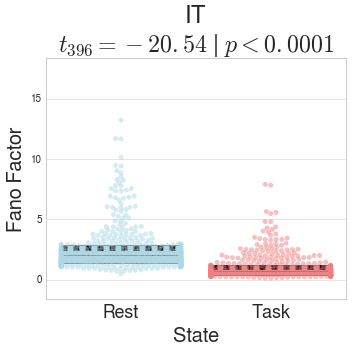

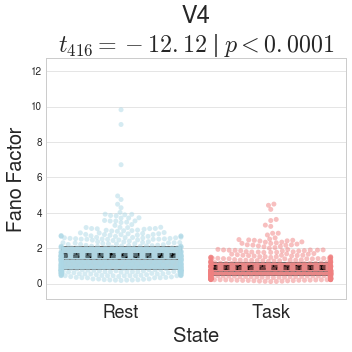

In [5]:
df_ff = {}
ps = []
ts = []
dof = []
for i in range(len(regions)):
    area = regions[i]
    df_ff[area] = {}
    df_ff[area]['Fano Factor'] = []
    df_ff[area]['State'] = []

    tmp = []
    for sess in range(len(ff_rest)):
        ff_diff = ff_task[sess][i]-ff_rest[sess][i]
        if not np.isnan(ff_diff):
            tmp.append(ff_diff)
            df_ff[area]['Fano Factor'].append(ff_rest[sess][i])
            df_ff[area]['State'].append('Rest')
            df_ff[area]['Fano Factor'].append(ff_task[sess][i])
            df_ff[area]['State'].append('Task')
    
    t, p = stats.ttest_1samp(tmp,0)
    ps.append(p)
    ts.append(t)
    dof.append(len(tmp)-1)
qs = mc.fdrcorrection0(ps)[1]
df_ff = pd.DataFrame(df_ff)

for i in range(len(regions)):
    area = regions[i]
    t = ts[i]
    p = qs[i]
    df = dof[i]
    ## Now plot
    plt.figure(figsize=(5,5))
    
    sns.swarmplot(x="State",y='Fano Factor',data=df_ff[area],
               palette=["#add8e6","#f08080"], alpha=0.5)
    sns.boxplot(x="State",y='Fano Factor',data=df_ff[area],
               palette=["#add8e6","#f08080"],
               meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
               medianprops={'linestyle':'-'},sym='',whis=0)
#     sns.boxplot(x="State",y='Fano Factor',
#                palette=["#add8e6","#f08080"],
#                data=df_ff[area],whis=np.inf)
#     sns.stripplot(x="State",y='Fano Factor',
#                palette=["#add8e6","#f08080"],
#                data=df_ff[area], alpha=0.5)

    if p < 0.0001: 
        p = '$p < 0.0001$'
    else:
        p = '$p = ' + str(round(p,3)) + '$'
    plt.title(area + '\n$t_{' + str(df) + '} = ' + str(round(t,2)) + '$ | ' + p,fontname='FreeSans',fontsize=24)
    plt.ylabel('Fano Factor',fontsize=20, fontname='FreeSans')
    plt.xlabel('State', fontsize=20,fontname='FreeSans')
    plt.xticks(fontsize=18,fontname='FreeSans')
    plt.ylim([np.min(df_ff[area]['Fano Factor'])-np.std(df_ff[area]['Fano Factor']),np.max(df_ff[area]['Fano Factor'])+3*np.std(df_ff[area]['Fano Factor'])]);
    plt.tight_layout()
    plt.savefig('../../figures/manuscriptFigures/SFig_FanoFactor/NHP3s_' + area + '_FF_Replication.pdf')

# Perform global analyses (i.e., averaged across all recordings)

In [6]:
globalFF = []

sesscount = 0
for trial in range(len(ff_rest)):
    
    tmp_FF = np.zeros((2,))
    
    zero_ind = np.where(np.isnan(ff_rest[trial])==False)[0]
    
    tmp_FF[0] = np.mean(ff_rest[trial][zero_ind])
    tmp_FF[1] = np.mean(ff_task[trial][zero_ind])
    globalFF.append(tmp_FF)
    
    sesscount += 1
    
globalFF = np.asarray(globalFF)

### Plot

FF Post- vs. Pre-stim:
FF rest: 0.954367313526
FF task: 0.531606566491
FF diff: -0.422760747035
	t = -17.384 | p = 9.82373137904e-58


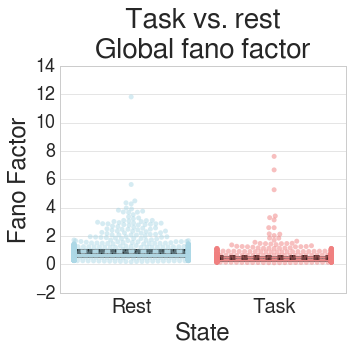

In [8]:
t, p = stats.ttest_rel(globalFF[:,1],globalFF[:,0])
print 'FF Post- vs. Pre-stim:'
print 'FF rest:', np.mean(globalFF[:,0])
print 'FF task:', np.mean(globalFF[:,1])
print 'FF diff:', np.mean(globalFF[:,1]) - np.mean(globalFF[:,0])
print '\tt =', round(t,3), '| p =', p

plt.figure(figsize=(5,5))
sns.swarmplot(data=[globalFF[:,0], globalFF[:,1]],
           palette=["#add8e6","#f08080"], alpha=0.5)
sns.boxplot(data=[globalFF[:,0], globalFF[:,1]],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
df = len(ff_rest)-1
plt.title('Task vs. rest\nGlobal fano factor',fontsize=28, y=1.02)
plt.ylabel('Fano Factor',fontsize=24)
plt.xticks(np.arange(0,2),['Rest', 'Task'], fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('State', fontsize=24)
# plt.ylim([np.min(globalFF[:,1])-np.std(globalFF[:,1]),np.max(globalFF[:,0])+1*np.std(globalFF[:,0])]);
# plt.ylim([-100000,500000]);
plt.tight_layout()
plt.savefig('../../figures/manuscriptFigures/SFig_FanoFactor/NHP3s_' + 'globalFF_Replication.png',dpi=300)